In [1]:
import os
import json
import math
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

C:\Users\alber\AppData\Local\Temp/ipykernel_5884/3344943526.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Working with data

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0, 1)])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="./", transform=transform)
# len(train_dataset)
EVAL = 0.1
train_set, val_set = torch.utils.data.random_split(train_dataset, [len(train_dataset)-int(len(train_dataset)*EVAL), int(len(train_dataset)*EVAL)])
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(10,10+num)], dim=0)

# Building VAE


## Encoder

In [32]:
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Encoder, self).__init__()
        self.encoder_conv = nn.Sequential(
            # -- 28x28 --> 14x14
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            # 14x14 --> 7x7
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            # 7x7 -> 4x4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
            # 4x4 -> 2x2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(),
        )
        self.encoder_full = nn.Sequential(
            nn.Linear(in_features=1024, out_features=1024),
            nn.LeakyReLU(),
        )
       
        self.mean = nn.Linear(in_features= 1024, out_features=latent_dim)
        self.var = nn.Linear(in_features= 1024, out_features=latent_dim)
    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, 2*2*256)
        x = self.encoder_full(x)
        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

## Decoder

In [39]:
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Decoder, self).__init__()

        self.linear1 = nn.Linear(in_features=latent_dim, out_features=1024)
        self.conv_decoder = nn.Sequential(
            # 2x2 -> 4x4
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(),
            # 4x4->7x7
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
            # # 7x7 --> 14x14
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            # # 14x14 --> 28x28
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            # # 28x28 --> 28x28
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
            
        )
    def forward(self, x):
        x = self.linear1(x)
        x = x.view(-1, 256, 2, 2)
        x = self.conv_decoder(x)
        return x
        

### Uzupełnij metodę losowania nowych przykładów w przestrzeni ukrytej

In [40]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = VAE_Encoder(latent_dim=latent_dim)
        self.decoder = VAE_Decoder(latent_dim=latent_dim)

        
    def reparameterization(self, mean, var):
        z = torch.randn_like(mean) * var + mean # Change to proper sampling
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [41]:
vae = VAE(latent_dim=128).to(device)

In [42]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [43]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    KLD               = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [44]:
num_epochs = 10
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
    L1_list = []
    for x, _ in iter(val_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 1907.512132645784, test L1 = 0.10991493989019951
Epoch 1 loss 992.2899633022053, test L1 = 0.09956808895506758
Epoch 2 loss 925.8650449380835, test L1 = 0.09530031899029905
Epoch 3 loss 889.5869753509141, test L1 = 0.09398977692298432
Epoch 4 loss 869.899125457022, test L1 = 0.09124871751570955
Epoch 5 loss 859.1439664486816, test L1 = 0.09226789868416939
Epoch 6 loss 848.4430877739817, test L1 = 0.08903610967892281
Epoch 7 loss 840.5047698594723, test L1 = 0.09148051264755269
Epoch 8 loss 833.3917593783575, test L1 = 0.09065190853273615
Epoch 9 loss 828.4057343307161, test L1 = 0.08883392315437184


In [45]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

C:\Users\alber\AppData\Roaming\Python\Python310\site-packages\torchvision\utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


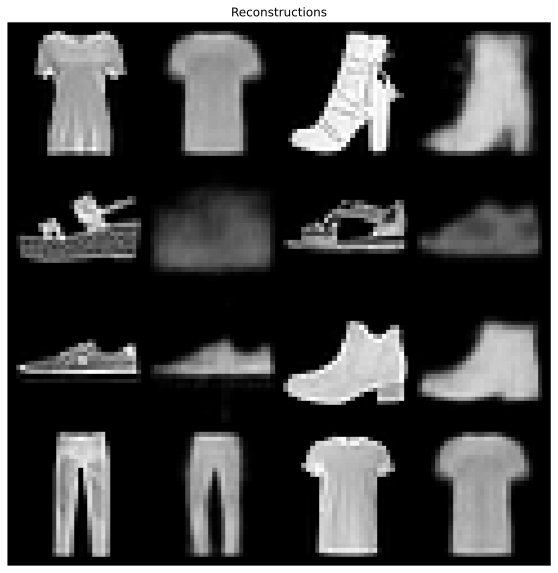

In [46]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [47]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

C:\Users\alber\AppData\Roaming\Python\Python310\site-packages\torchvision\utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


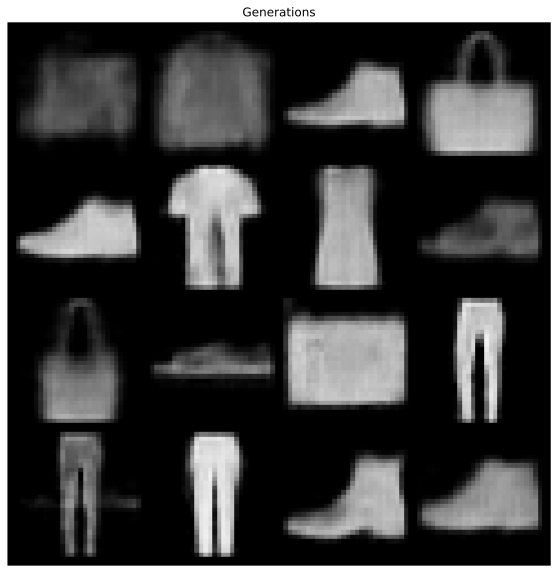

In [48]:
generate_images(vae, 16 , device)